#Problème n°1

La bonne transmission de signaux électromagnétiques dans l'atmosphère peut dépendre de la météo. La pluie affecte notoirement les échanges entre les antennes relais des réseaux mobiles actuels. C'est une gêne, mais aussi une opportunité: l'atténuation des ondes électromagnétiques due à la pluie peut être mesurée et utilisée comme un moyen de quantifier les précipitations.

Dans ce problème, on s'intéresse à la conversion de **l'atténuation**, définie comme un rapport entre puissance émise et puissance reçue, en un **taux de pluie moyen** le long de segments physiques dont les extrémités sont des antennes relais.

Evidemment, d'autres éléments que le pluie, plus ou moins bien connus, peuvent influencer l'atténuation. La simulation sur laquelle nous allons travailler, qui porte sur un millier de paires d'antennes virtuelles, est construite de la façon suivante:

- pour une paire d'antennes donnée, on modélise une série temporelle de taux de pluie moyen par un processus stochastique dont les paramètres dépendent entre autres de la distance qui sépare les antennes.
- pour en tirer des atténuations, on applique à cette série les transformations suivantes:
    - un filtre convolutif, censé modéliser l'impact du film d'eau se formant sur les antennes au cours d'un épisode de pluie (ce film qui s'épaissit augmente progressivement l'atténuation).
    - une conversion non-linéaire, tirée d'un modèle physique, est appliquée composante à composante.
    - un bruit haute-fréquence
    - un bruit basse-fréquence

La cellules suivantes permettent de récupérer les briques de code utiles, de construire un dictionnaire contenant des identifiants de paires d'antennes (clefs) et les distances les séparant (valeurs). La dernière cellule montre des exemples de séries temporelles simulées pour quelques paires.

In [1]:
# Local clone
! git clone https://github.com/nanopiero/exam_2025.git
! cp exam_2025/utils/utils_probleme1.py .

Cloning into 'exam_2025'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 115 (delta 18), reused 7 (delta 7), pack-reused 78 (from 2)
Receiving objects: 100% (115/115), 3.24 MiB | 4.82 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [2]:
# Imports
from os.path import join, isdir, isfile
from os import listdir as ls
import copy
import torch
import numpy as np
import sys
from utils_probleme1 import create_dataloader

In [4]:
# Dictionnaire des "distances" (générées au hasard)
idx2distance_train = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(0, 1000)}
idx2distance_val = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(1000, 1200)}

# Paramètres de la simulation
duration = 4096  # durée de la série temporelle (unité : minutes)
batch_size = 100  # taille d'un échantillon

# Création du dataloader (il contient toutes les étapes de la simulation)
# (en une époque, chaque paire d'antennes du dictionnaire idx2distance
# a été tirée exactement une fois)
trainloader = create_dataloader(duration, idx2distance_train, batch_size)

# Génération d'un batch contenant des séries temporelles
for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
    break

In [ ]:
import matplotlib.pyplot as plt

for k in range(5):
  plt.figure(figsize=(10, 6))
  plt.plot(np.arange(duration), rain_rates[k], label='rain rates')
  plt.plot(np.arange(duration), attenuations[k], label='attenuations')
  plt.title(f"Attenuations et taux de pluie moyen pour la paire n°{ids[k].item():.0f} (distance: {dists[k].item():.2f} km)")
  plt.xlabel('Time (minutes)')
  plt.ylabel('DB (atten.) ou mm/h (pluie)')
  plt.ylim(-1,6)
  plt.legend()
  plt.show()

## Partie I : Un réseau de neurones générique

Dans cette partie, on entraîne un UNet1D à faire le lien entre atténuations
et taux de pluie. Les cellules suivantes contiennent les blocs du UNet1D et son montage :

In [4]:
##############################################################################################
################################     UNet 1D building blokcs    ##############################
import torch
import torch.nn as nn
import torch.nn.functional as F

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool1d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        else:
            self.up = nn.ConvTranspose1d(in_ch, in_ch, kernel_size=2, stride=2)

        self.conv = double_conv(2*in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2)))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


################################################################################
######################################## class UNet1D ##########################

class UNet1D(nn.Module):
    def __init__(self, n_channels, n_classes, size=64):
        super(UNet1D, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)
        self.n_classes=n_classes

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)
        return   x





**Consignes:** \
1) Entraîner sur GPU un UNet 1D à restituer les taux de pluie à partir des atténuations.
- On utilisera la MSE comme fonction de coût et comme score. Dans les deux cas, prendre une marge de deux heures au début et à la fin de la série temporelle pour éviter les effets de bord.
- La descente de gradient stochastique sera pilotée par l'optimiseur ADAM (paramétrage standard) sur cinquante époques.

2) Tracer la courbe d'apprentissage de manière à montrer l'évolution:
- des performances en généralisation sur de nouvelles données issues des paires d'antennes vues à l'entraînement.
- des performances en généralisation sur des séries issues de paires d'antennes indépendantes (celles de *idx2distance_val*).


3) Visualiser les prédictions après apprentissage

Gomplétons le snippet suivant pour entraîner un UNet en répondant aux contraintes de l'énoncé:

**Prompt**: I've two loaders that provide synthetic batched time series of length 4096 (batch size of 100) named attenuations (inputs) and rain_rates (targets).
Could you complete the following snippet to train my UNet1D to minimize MSE through a standard ADAM optimization, taking into account the following constraints:
- MSEs should not be calculated on the 2 * 60 first and last components of outputs and targets (2 hours margins).
- At each epoch, mean MSE on the training set and on the validation set will be stored in convenient lists.
- train the model over 50 epochs
- plot the two curves from the lists once the training is done.

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Dictionnaire des "distances" (générées au hasard)
idx2distance_train = {i: 0.2 + 1.8 * torch.rand((1,)).item() for i in range(0, 1000)}
idx2distance_val = {i: 0.2 + 1.8 * torch.rand((1,)).item() for i in range(1000, 1200)}

# Paramètres de la simulation
duration = 4096  # durée de la série temporelle (unité : minutes)
batch_size = 100  # taille d'un échantillon

# Création des dataloaders
trainloader = create_dataloader(duration, idx2distance_train, batch_size)
valloader = create_dataloader(duration, idx2distance_val, batch_size)

n_channels = 1
n_classes = 1
model = UNet1D(n_channels, n_classes, size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Listes pour stocker les MSEs
train_losses = []
val_losses = []

num_epochs = 70
margin = 2 * 60  # Marges de 2 heures

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
        # ajout nécessaire d'une dim. pour les canaux (l'IA n'y pense pas systématiquement)
        attenuations, rain_rates = attenuations.to(device).unsqueeze(1), rain_rates.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(attenuations)

        # Exclure les premières et dernières 120 valeurs
        loss = criterion(outputs[:, :, margin:-margin], rain_rates[:, :, margin:-margin])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(trainloader))

    # Évaluation sur le set de validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(valloader):
            attenuations, rain_rates = attenuations.to(device).unsqueeze(1), rain_rates.to(device).unsqueeze(1)
            outputs = model(attenuations)
            loss = criterion(outputs[:, :, margin:-margin], rain_rates[:, :, margin:-margin])
            val_loss += loss.item()

    val_losses.append(val_loss / len(valloader))

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")



Epoch 1/70 - Train Loss: 0.346297, Val Loss: 0.624518
Epoch 2/70 - Train Loss: 0.179538, Val Loss: 0.628213
Epoch 3/70 - Train Loss: 0.156344, Val Loss: 0.652379
Epoch 4/70 - Train Loss: 0.147267, Val Loss: 0.571306
Epoch 5/70 - Train Loss: 0.144320, Val Loss: 0.388715
Epoch 6/70 - Train Loss: 0.142154, Val Loss: 0.179184
Epoch 7/70 - Train Loss: 0.138053, Val Loss: 0.146808
Epoch 8/70 - Train Loss: 0.139890, Val Loss: 0.137255
Epoch 9/70 - Train Loss: 0.140105, Val Loss: 0.132502
Epoch 10/70 - Train Loss: 0.136793, Val Loss: 0.140482
Epoch 11/70 - Train Loss: 0.135299, Val Loss: 0.131174
Epoch 12/70 - Train Loss: 0.139041, Val Loss: 0.138739
Epoch 13/70 - Train Loss: 0.134428, Val Loss: 0.130425
Epoch 14/70 - Train Loss: 0.130505, Val Loss: 0.135604
Epoch 15/70 - Train Loss: 0.134543, Val Loss: 0.130523
Epoch 16/70 - Train Loss: 0.134054, Val Loss: 0.126801
Epoch 17/70 - Train Loss: 0.131717, Val Loss: 0.130825
Epoch 18/70 - Train Loss: 0.130303, Val Loss: 0.132539
Epoch 19/70 - Train

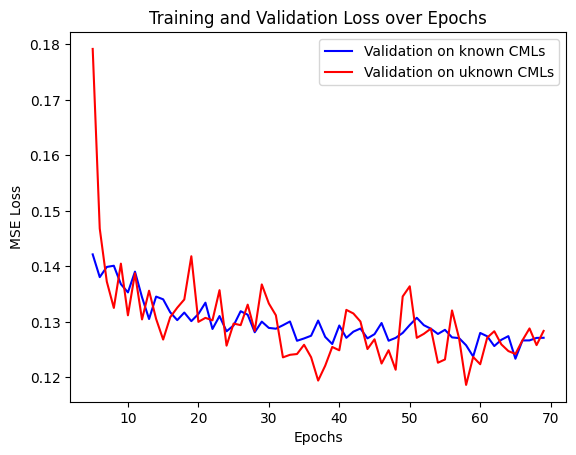

In [53]:
# Affichage des courbes de perte
plt.figure()
plt.plot(range(5, num_epochs), train_losses[5:], color='blue', label='Validation on known CMLs')
plt.plot(range(5, num_epochs), val_losses[5:], color='red', label='Validation on uknown CMLs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

## Partie II

Dans la première partie, le modèle était générique: la specificité de la paire d'antenne n'était pas prise en compte. On se propose de le faire en combinant un réseau générique à un perceptron spécifique, de sorte que la sortie $Z$ s'exprime sous la forme: \
$$Z = F(X, k) = f^{\tiny{Perceptron}}_{\alpha_k}(f^{\tiny{UNet}}_{\theta}(X))$$ \
 où $f^{\tiny{UNet}}_{\theta}(.)$ représente la fonction *forward* d'un UNet et $f^{\tiny{Perceptron}}_{\alpha_k}(.)$, la fonction forward du perceptron associé à la paire d'antennes d'identifiant $k$. \

Il s'agit donc en premier lieu d'adjoindre au UNet de la partie I autant de perceptrons que le jeu d'entraînement compte de paires d'antennes, ce qui se fait grâce aux lignes suivantes:

In [ ]:
# Pour l'ajout de 1200 perceptrons à deux couches:
self.num_pairs = 1200
self.input_size_fc_layer = 5
self.hidden_size_fc_layer = 5
# Liste des premières couches
self.linears1 = nn.ModuleList([nn.Linear(self.input_size_fc_layer,
                                         self.hidden_size_fc_layer) for i in range(self.num_pairs)])
# Liste des secondes couches
self.linears2 = nn.ModuleList([nn.Linear(self.hidden_size_fc_layer,
                                         1) for i in range(self.num_pairs)])


**Consignes:** \
1) Définir une nouvelle classe de réseau en modifiant la classe UNet1D (dans utils_probleme1.py).
Ajouter ces perceptrons au réseau.

2) Fixer *self.n_classes* de façon à ce que la sortie du UNet soit compatible avec l'entrée du perceptron.

3) Modifications de la fonction forward:
- elle doit prendre comme arguments un batch d'entrées et un batch d'identifiants.

- après les étapes propres au UNet, elle doit appliquer le perceptron d'indice k à une série provenant de la paire n°k. La cellule de code suivante fournit un exemple dont on pourra directement s'inspirer.

4) Suivre les performances en généralisation sur les paires d'antennes du jeu d'entraînement et sur les deux cents paires de validation. Commenter.




In [10]:
def apply_perceptron(self, UNet_output, ids):
    for i in range(ids.shape[0]):
        id = ids[i]
        # application de la première couche
        x = self.linears1[id](UNet_output[i].transpose(0,1).contiguous())
        x = self.relu(x)
        # application de la seconde couche
        x = self.linears2[id](x)
        # correction multiplicative de UNet_output
        UNet_output[i, 0] *= 1 + x.transpose(0,1).contiguous()
    return UNet_output[:,0]


Nouvelle classe de réseau:

In [40]:
class UNet1D_plus_specific_modules(nn.Module):
    def __init__(self, n_channels, n_classes, size=64):
        super(UNet1D_plus_specific_modules, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)
        self.n_classes=n_classes
        # Pour l'ajout de 1200 perceptrons à deux couches:
        self.num_pairs = 1200
        self.input_size_fc_layer = 5
        self.hidden_size_fc_layer = 5
        # Liste des premières couches
        self.linears1 = nn.ModuleList([nn.Linear(self.input_size_fc_layer,
                                                self.hidden_size_fc_layer) for i in range(self.num_pairs)])
        # Liste des secondes couches
        self.linears2 = nn.ModuleList([nn.Linear(self.hidden_size_fc_layer,
                                                1) for i in range(self.num_pairs)])
        # ajout d'un relu pour apply_percpetron
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, ids):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = self.apply_perceptron(x, ids)
        return   x

    def apply_perceptron(self, UNet_output, ids):
        for i in range(ids.shape[0]):
            id = ids[i]
            # application de la première couche
            x = self.linears1[id](UNet_output[i].transpose(0,1).contiguous())
            x = self.relu(x)
            # application de la seconde couche
            x = self.linears2[id](x)
            # correction multiplicative de UNet_output
            UNet_output[i, 0] *= 1 + x.squeeze(1)
        return UNet_output[:,0]


# test :
for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
    break

model = UNet1D_plus_specific_modules(1, 5, size=32)
model(attenuations.unsqueeze(1), ids).shape

torch.Size([100, 4096])

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Dictionnaire des "distances" (générées au hasard)
idx2distance_train = {i: 0.2 + 1.8 * torch.rand((1,)).item() for i in range(0, 1000)}
idx2distance_val = {i: 0.2 + 1.8 * torch.rand((1,)).item() for i in range(1000, 1200)}

# Paramètres de la simulation
duration = 4096  # durée de la série temporelle (unité : minutes)
batch_size = 100  # taille d'un échantillon

# Création des dataloaders
trainloader = create_dataloader(duration, idx2distance_train, batch_size)
valloader = create_dataloader(duration, idx2distance_val, batch_size)

n_channels = 1
n_classes = 1

# Modèle 2 : UNet1D_plus_specific_modules
model2 = UNet1D_plus_specific_modules(1, 5, size=32).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.MSELoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

# Listes pour stocker les MSEs du second modèle
train_losses2, val_losses2 = [], []

num_epochs = 100
margin = 2 * 60  # Marges de 2 heures

for epoch in range(num_epochs):
    model2.train()
    running_loss2 = 0.0

    for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
        attenuations, rain_rates, ids = attenuations.to(device).unsqueeze(1), \
                                        rain_rates.to(device), ids.to(device)

        # Training for model2
        optimizer2.zero_grad()
        outputs2 = model2(attenuations, ids)
        loss2 = criterion(outputs2[:, margin:-margin], rain_rates[:, margin:-margin])
        loss2.backward()
        optimizer2.step()
        running_loss2 += loss2.item()

    train_losses2.append(running_loss2 / len(trainloader))

    # Évaluation sur le set de validation
    model2.eval()
    val_loss2 = 0.0
    with torch.no_grad():
        for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(valloader):
            attenuations, rain_rates, ids = attenuations.to(device).unsqueeze(1), \
                                            rain_rates.to(device), ids.to(device)

            outputs2 = model2(attenuations, ids)
            loss2 = criterion(outputs2[:, margin:-margin], rain_rates[:,  margin:-margin])
            val_loss2 += loss2.item()

    val_losses2.append(val_loss2 / len(valloader))

    print(f"Epoch {epoch+1}/{num_epochs} - Model2 Train Loss: {train_losses2[-1]:.6f}, Val Loss: {val_losses2[-1]:.6f}")


Epoch 1/100 - Model2 Train Loss: 0.626149, Val Loss: 0.687557
Epoch 2/100 - Model2 Train Loss: 0.315608, Val Loss: 0.607628
Epoch 3/100 - Model2 Train Loss: 0.254187, Val Loss: 0.464188
Epoch 4/100 - Model2 Train Loss: 0.242548, Val Loss: 0.400605
Epoch 5/100 - Model2 Train Loss: 0.231457, Val Loss: 0.319768
Epoch 6/100 - Model2 Train Loss: 0.232319, Val Loss: 0.236649
Epoch 7/100 - Model2 Train Loss: 0.224514, Val Loss: 0.233754
Epoch 8/100 - Model2 Train Loss: 0.221103, Val Loss: 0.208446
Epoch 9/100 - Model2 Train Loss: 0.216975, Val Loss: 0.215661
Epoch 10/100 - Model2 Train Loss: 0.216973, Val Loss: 0.219760
Epoch 11/100 - Model2 Train Loss: 0.212580, Val Loss: 0.227291
Epoch 12/100 - Model2 Train Loss: 0.211838, Val Loss: 0.203234
Epoch 13/100 - Model2 Train Loss: 0.207189, Val Loss: 0.213673
Epoch 14/100 - Model2 Train Loss: 0.205083, Val Loss: 0.213748
Epoch 15/100 - Model2 Train Loss: 0.202970, Val Loss: 0.226555
Epoch 16/100 - Model2 Train Loss: 0.201656, Val Loss: 0.208905
E

<Figure size 640x480 with 0 Axes>

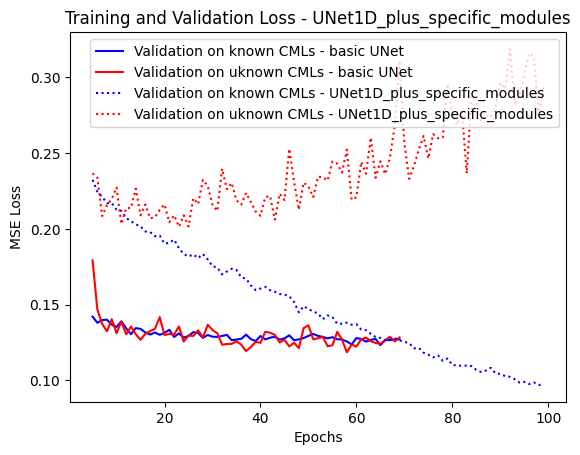

In [54]:
# Affichage des courbes de perte
plt.figure()
# Affichage des courbes de perte
plt.figure()
plt.plot(range(5, 70), train_losses[5:], color='blue', label='Validation on known CMLs - basic UNet')
plt.plot(range(5, 70), val_losses[5:], color='red', label='Validation on uknown CMLs - basic UNet')
plt.plot(range(5, 100), train_losses2[5:], color='blue', label='Validation on known CMLs - UNet1D_plus_specific_modules', linestyle=':')
plt.plot(range(5, 100), val_losses2[5:], color='red', label='Validation on uknown CMLs - UNet1D_plus_specific_modules', linestyle=':')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss - UNet1D_plus_specific_modules')
plt.show()

On pouvait s'attendre à une amélioration sur les liens "connus" du jeu d'entraînement, mais ça n'est pas le cas sur seulement 50 époques. J'ai poussé jusqu'à 100 époques pour montrer la plus-value des modules spécifiques. Par contre les performances en génralisation sur des liens inconnus sont clairement dégradées.

## Partie III

La solution proposée dans la partie II a un défaut: les performances chutent sur les paires d'antennes qui n'ont pas été rencontrées pendant l'entraînement. Pour le corriger, on se propose de suivre la méthode suivante:
- ajouter un perceptron "générique" de même architecture que les perceptrons spécifiques.
- entraîner le réseau de la partie II en remplaçant une fois sur quatre l'identifiant de la paire d'antennes par l'indice du perceptron générique.
- après cinquante époques, geler les poids de la partie générique et prolonger l'apprentissage des perceptrons spécifiques sur une vingtaine d'époque.

**Consignes:** \

1) Mettre en oeuvre cette méthode

2) Conclure sur son efficacité

In [45]:
class UNet1D_plus_generic_and_specific_modules(nn.Module):
    def __init__(self, n_channels, n_classes, size=64):
        super(UNet1D_plus_generic_and_specific_modules, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)
        self.n_classes=n_classes
        # Pour l'ajout de 1200 perceptrons à deux couches:
        self.num_pairs = 1200
        self.input_size_fc_layer = 5
        self.hidden_size_fc_layer = 5
        # Liste des premières couches (on a ajouté un perceptron)
        self.linears1 = nn.ModuleList([nn.Linear(self.input_size_fc_layer,
                                                self.hidden_size_fc_layer) for i in range(self.num_pairs + 1)])
        # Liste des secondes couches (ici aussi, on a ajouté un perceptron)
        self.linears2 = nn.ModuleList([nn.Linear(self.hidden_size_fc_layer,
                                                1) for i in range(self.num_pairs + 1)])
        # ajout d'un relu pour apply_percpetron
        self.relu = nn.ReLU(inplace=True)
        self.use_only_specific = False
        self.use_specific = True

    def forward(self, x, ids):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = self.apply_perceptron(x, ids)
        return   x

    def apply_perceptron(self, UNet_output, ids):
        for i in range(ids.shape[0]):
            # percpetrons d'indice 0 une fois sur 4:
            id = 1 + ids[i] if ((torch.rand(1) > 0.25 or self.use_only_specific) and self.use_specific) else 0
            # application de la première couche
            x = self.linears1[id](UNet_output[i].transpose(0,1).contiguous())
            x = self.relu(x)
            # application de la seconde couche
            x = self.linears2[id](x)
            # correction multiplicative de UNet_output
            UNet_output[i, 0] *= 1 + x.squeeze(1)
        return UNet_output[:,0]

    def freeze_generic_parts(self):
        # Ajout d'une fonction permettant de geler les poids génériques
        # Freeze all parameters
        for param in self.parameters():
            param.requires_grad = False

        # Unfreeze parameters in linears1 and linears2
        for linear in self.linears1:
            for param in linear.parameters():
                param.requires_grad = True

        for linear in self.linears2:
            for param in linear.parameters():
                param.requires_grad = True

# test :
for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
    break

# model = UNet1D_plus_generic_and_specific_modules(1, 5, size=32)
# model(attenuations.unsqueeze(1), ids).shape

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Dictionnaire des "distances" (générées au hasard)
idx2distance_train = {i: 0.2 + 1.8 * torch.rand((1,)).item() for i in range(0, 1000)}
idx2distance_val = {i: 0.2 + 1.8 * torch.rand((1,)).item() for i in range(1000, 1200)}

# Paramètres de la simulation
duration = 4096  # durée de la série temporelle (unité : minutes)
batch_size = 100  # taille d'un échantillon

# Création des dataloaders
trainloader = create_dataloader(duration, idx2distance_train, batch_size)
valloader = create_dataloader(duration, idx2distance_val, batch_size)

n_channels = 1
n_classes = 1

# Modèle 2 : UNet1D_plus_specific_modules
model3 = UNet1D_plus_generic_and_specific_modules(1, 5, size=32).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.MSELoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

# Listes pour stocker les MSEs du second modèle
train_losses3, val_losses3 = [], []

num_epochs = 100
margin = 2 * 60  # Marges de 2 heures

for epoch in range(num_epochs):
    model3.train()
    model3.use_specific = True
    running_loss3 = 0.0

    for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
        attenuations, rain_rates, ids = attenuations.to(device).unsqueeze(1), \
                                        rain_rates.to(device), ids.to(device)

        # Training for model3
        optimizer3.zero_grad()
        outputs3 = model3(attenuations, ids)
        loss3 = criterion(outputs3[:, margin:-margin], rain_rates[:, margin:-margin])
        loss3.backward()
        optimizer3.step()
        running_loss3 += loss3.item()

    train_losses3.append(running_loss3 / len(trainloader))

    # Évaluation sur le set de validation
    model3.eval()
    model3.use_specific = False
    val_loss3 = 0.0
    with torch.no_grad():
        for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(valloader):
            attenuations, rain_rates, ids = attenuations.to(device).unsqueeze(1), \
                                            rain_rates.to(device), ids.to(device)
            # multiply there by 0 to use the generic part for validation on unknown links
            outputs3 = model3(attenuations, ids)
            loss3 = criterion(outputs3[:, margin:-margin], rain_rates[:,  margin:-margin])
            val_loss3 += loss3.item()

    val_losses3.append(val_loss3 / len(valloader))

    print(f"Epoch {epoch+1}/{num_epochs} - Model3 Train Loss: {train_losses3[-1]:.6f}, Val Loss: {val_losses3[-1]:.6f}")


Epoch 1/100 - Model3 Train Loss: 0.605827, Val Loss: 0.799992
Epoch 2/100 - Model3 Train Loss: 0.289164, Val Loss: 0.724204
Epoch 3/100 - Model3 Train Loss: 0.222443, Val Loss: 0.456698
Epoch 4/100 - Model3 Train Loss: 0.204033, Val Loss: 0.220970
Epoch 5/100 - Model3 Train Loss: 0.199007, Val Loss: 0.166448
Epoch 6/100 - Model3 Train Loss: 0.196974, Val Loss: 0.149838
Epoch 7/100 - Model3 Train Loss: 0.194610, Val Loss: 0.148687
Epoch 8/100 - Model3 Train Loss: 0.191849, Val Loss: 0.150069
Epoch 9/100 - Model3 Train Loss: 0.186073, Val Loss: 0.142619
Epoch 10/100 - Model3 Train Loss: 0.188608, Val Loss: 0.161208
Epoch 11/100 - Model3 Train Loss: 0.185875, Val Loss: 0.140403
Epoch 12/100 - Model3 Train Loss: 0.184665, Val Loss: 0.138516
Epoch 13/100 - Model3 Train Loss: 0.182157, Val Loss: 0.143088
Epoch 14/100 - Model3 Train Loss: 0.185436, Val Loss: 0.146838
Epoch 15/100 - Model3 Train Loss: 0.176857, Val Loss: 0.140526
Epoch 16/100 - Model3 Train Loss: 0.179769, Val Loss: 0.145268
E

In [48]:
# fine tuning on the 20 last epochs
model3.use_only_specific = True # to avoid generic module
model3.freeze_generic_parts() # To freeze parameters

for epoch in range(20):
    model3.train()
    model3.use_specific = True
    running_loss3 = 0.0

    for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
        attenuations, rain_rates, ids = attenuations.to(device).unsqueeze(1), \
                                        rain_rates.to(device), ids.to(device)

        # Training for model3
        optimizer3.zero_grad()
        outputs3 = model3(attenuations, ids)
        loss3 = criterion(outputs3[:, margin:-margin], rain_rates[:, margin:-margin])
        loss3.backward()
        optimizer3.step()
        running_loss3 += loss3.item()

    train_losses3.append(running_loss3 / len(trainloader))

    # Évaluation sur le set de validation
    model3.eval()
    model3.use_specific = False
    val_loss3 = 0.0
    with torch.no_grad():
        for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(valloader):
            attenuations, rain_rates, ids = attenuations.to(device).unsqueeze(1), \
                                            rain_rates.to(device), ids.to(device)

            outputs3 = model3(attenuations, ids)
            loss3 = criterion(outputs3[:, margin:-margin], rain_rates[:,  margin:-margin])
            val_loss3 += loss3.item()

    val_losses3.append(val_loss3 / len(valloader))

    print(f"Epoch {epoch+1}/{num_epochs} - Model3 Train Loss: {train_losses3[-1]:.6f}, Val Loss: {val_losses3[-1]:.6f}")


Epoch 1/100 - Model3 Train Loss: 0.114604, Val Loss: 0.127271
Epoch 2/100 - Model3 Train Loss: 0.114629, Val Loss: 0.130057
Epoch 3/100 - Model3 Train Loss: 0.113976, Val Loss: 0.130236
Epoch 4/100 - Model3 Train Loss: 0.112705, Val Loss: 0.124508
Epoch 5/100 - Model3 Train Loss: 0.110453, Val Loss: 0.124532
Epoch 6/100 - Model3 Train Loss: 0.112469, Val Loss: 0.128421
Epoch 7/100 - Model3 Train Loss: 0.110873, Val Loss: 0.124319
Epoch 8/100 - Model3 Train Loss: 0.109154, Val Loss: 0.123451
Epoch 9/100 - Model3 Train Loss: 0.107457, Val Loss: 0.126075
Epoch 10/100 - Model3 Train Loss: 0.106602, Val Loss: 0.129069
Epoch 11/100 - Model3 Train Loss: 0.107489, Val Loss: 0.126816
Epoch 12/100 - Model3 Train Loss: 0.107885, Val Loss: 0.126936
Epoch 13/100 - Model3 Train Loss: 0.105029, Val Loss: 0.128938
Epoch 14/100 - Model3 Train Loss: 0.105484, Val Loss: 0.131032
Epoch 15/100 - Model3 Train Loss: 0.103989, Val Loss: 0.122813
Epoch 16/100 - Model3 Train Loss: 0.103414, Val Loss: 0.125689
E

<Figure size 640x480 with 0 Axes>

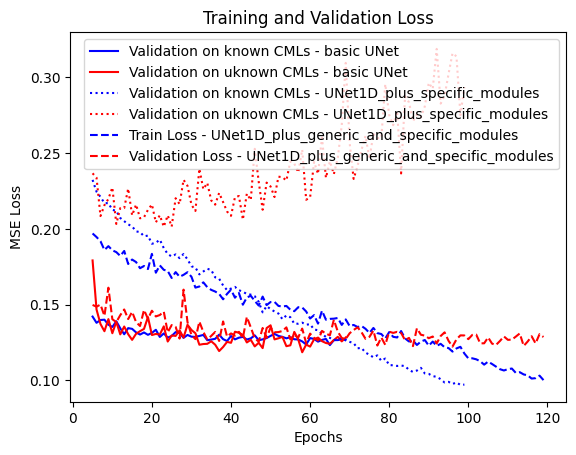

In [56]:
# Affichage des courbes de perte
plt.figure()
# Affichage des courbes de perte
plt.figure()
plt.plot(range(5, 70), train_losses[5:], color='blue', label='Validation on known CMLs - basic UNet')
plt.plot(range(5, 70), val_losses[5:], color='red',label='Validation on uknown CMLs - basic UNet')
plt.plot(range(5, 100), train_losses2[5:], color='blue',label='Validation on known CMLs - UNet1D_plus_specific_modules', linestyle=':')
plt.plot(range(5, 100), val_losses2[5:], color='red',label='Validation on uknown CMLs - UNet1D_plus_specific_modules', linestyle=':')
plt.plot(range(5, 100 + 20), train_losses3[5:], color='blue',label='Train Loss - UNet1D_plus_generic_and_specific_modules', linestyle='--')
plt.plot(range(5, 100 + 20), val_losses3[5:], color='red',label='Validation Loss - UNet1D_plus_generic_and_specific_modules', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Avec un module terminal générique supplémentaire, on retrouve les mêmes performances qu'à la partie II sur les liens qui n'ont pas été vus à l'entraînement. En poussant un peu l'apprentissage des modules spécifiques, on obtient des scores comparables à ceux de la partie II sur les liens connus.